## AST/STAT 5731


#### Claudia Scarlata

## Poisson regression

Today we will review how to implement:

- Poisson regression models in PyMC,
- Negative Binomial models
- Zero Inflated models
- The effecto of truncating the data. 

### Poisson
When your data are counts of some sort you will most likely use a  Poisson distribution. 
Remember that the Poisson distribution is used to model to describe the probability of a given number of events occurring on a fixed time/space interval. It assumes that the events occur indipendently of each other. The only parameter in the Poisson distribution is the mean $\lambda$.

$$p(y|\lambda)=\frac{e^{-\lambda}\lambda^y}{y!}$$

where x=0,1,2,...

Poisson regression, a generalized form of linear models, can be used when we suspect that the mean parameter is depends on another quantity.

In this case we assume that the response variable Y has a Poisson distribution, and we use the exponential function as the inverse link function, to make sure that the values returned by the linear models are always positive. In other words, we set:

$$ \lambda = e^{\beta_0 + X\beta_1}$$

Data for this exercise are taken from the paper "X-ray luminosities of SDSS DR7 clusters from RASS" ([Wang+, 2014](https://ui.adsabs.harvard.edu/abs/2014MNRAS.439..611W/abstract)) as well as the Globular Cluster data we showed in class.

During the lab time and left as HW to finish:

1- Using the file on canvas, extend the globular cluster analysis to simultaneously include:

   > absolute luminosity M_V [col10]
   >
   > "Dynamical mass" of the galaxy [col21]

You may want to consider the Log of the Masses.



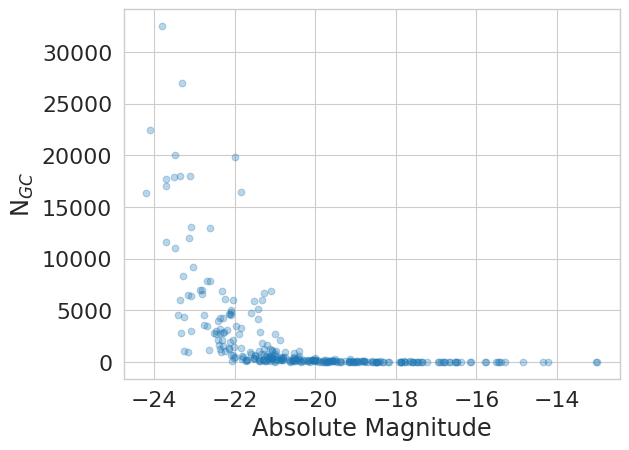

Text(0, 0.5, 'Log(1+N$_{GC}$)')

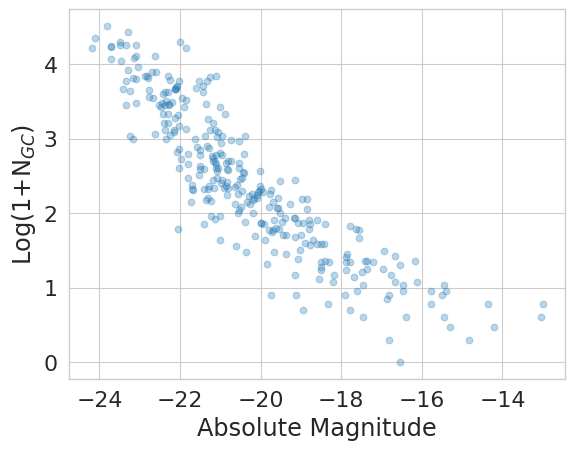

In [1]:
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.io import fits
import pandas as pd
import pymc as pm
from astropy.io import ascii
from astropy.table import Table
import arviz as az
sns.set_style("whitegrid", {"xtick.major.size": 0, "ytick.major.size": 0})
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 2.5})


#data = ascii.read('GCs.csv')
#x=data['MV_T'].data
#y=data['N_GC'].data

data = ascii.read('GC_allcolumns.txt')
data

x=data['MV_T'].data
y=data['N_GC'].data

plt.scatter(x,y,alpha=0.3)
#plt.yscale('log')
plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'N$_{GC}$')
plt.show()

plt.scatter(x,np.log10(1+y),alpha=0.3)
plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'Log(1+N$_{GC}$)')

In [26]:
import csv
import dis
import inspect
import os
import sys
import time

import arviz as az
import astropy
#import astroquery
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from pymc import Model, Normal, Gamma, find_MAP

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing as preproc

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
pp = pprint.PrettyPrinter(indent=4)

## set seed for reproducibility
random.seed(5731)

## import data
dfc = pd.read_csv('clusters_xrays.csv')
display(dfc.describe())
dfgc = ascii.read('GC_allcolumns.txt').to_pandas()#.replace(-9999, np.nan)
display(dfgc.describe());

,LX,Ngal
count,1030.000000,1030.000000
mean,0.050871,13.330097
std,0.089347,16.666854
min,0.000008,3.000000
25%,0.010061,5.000000
50%,0.025341,8.000000
75%,0.049777,14.750000
max,1.014745,154.000000


,RA,DEC,D,e1,A_V,MV_T,e2,M_K,e3,N_GC,...,e5,R_e,e6,M_d,e6_1,M_G,e8,M_B,el,eu
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.00000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,-23.979294,-33.365019,6.907239,-30.678350,0.135367,-20.311178,0.247407,6543.111411,505.170394,2057.814478,...,-2047.718182,-1072.900067,-1110.570505,-2550.573044,-2558.63163,7.812054,0.110606,-7876.753838,-7877.476936,-7877.975253
std,580.790966,581.191404,584.606585,580.385908,0.196881,2.126069,0.116528,81948.005957,8306.564171,4510.222699,...,4049.288834,3107.041290,3147.838511,4375.297599,4370.56382,1.113858,0.060663,4096.998665,4095.602673,4094.640323
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,-24.190000,0.200000,-9999.000000,-9999.000000,0.000000,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,5.140000,0.000000,-9999.000000,-9999.000000,-9999.000000
25%,3.669255,-33.233927,15.820000,0.560000,0.044000,-21.850000,0.200000,-25.065000,0.102000,50.000000,...,2.400000,1.220000,0.050000,-9999.000000,-9999.00000,7.040000,0.070000,-9999.000000,-9999.000000,-9999.000000
50%,11.699267,8.154306,20.150000,1.500000,0.084000,-20.800000,0.200000,-23.713000,0.104000,220.000000,...,4.600000,2.460000,0.160000,10.571000,0.03200,7.780000,0.110000,-9999.000000,-9999.000000,-9999.000000
75%,12.882202,27.060767,36.200000,4.090000,0.157000,-19.060000,0.250000,-21.708000,0.110000,1497.000000,...,8.600000,4.800000,0.410000,11.284000,0.04600,8.660000,0.130000,-9999.000000,-9999.000000,-9999.000000
max,23.641519,75.370944,284.200000,19.900000,2.583000,-13.000000,1.440000,999999.000000,99999.000000,32500.000000,...,46.500000,55.000000,20.000000,12.726000,0.21000,10.120000,0.570000,10.320000,9.950000,0.620000


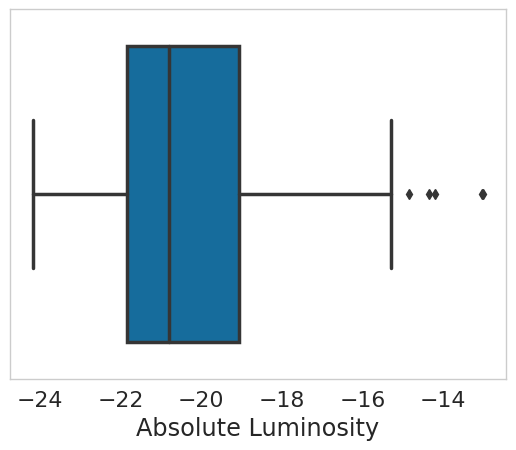

In [31]:
plot = sns.boxplot(data=dfgc, x='MV_T')
plt.xlabel('Absolute Luminosity')
plt.show()

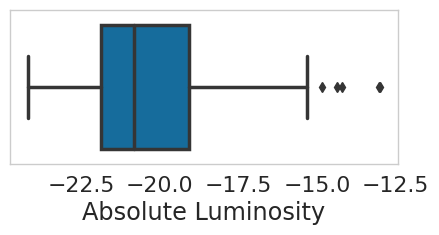

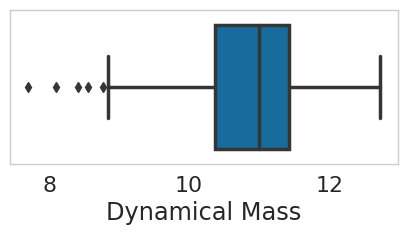

<Figure size 800x800 with 0 Axes>

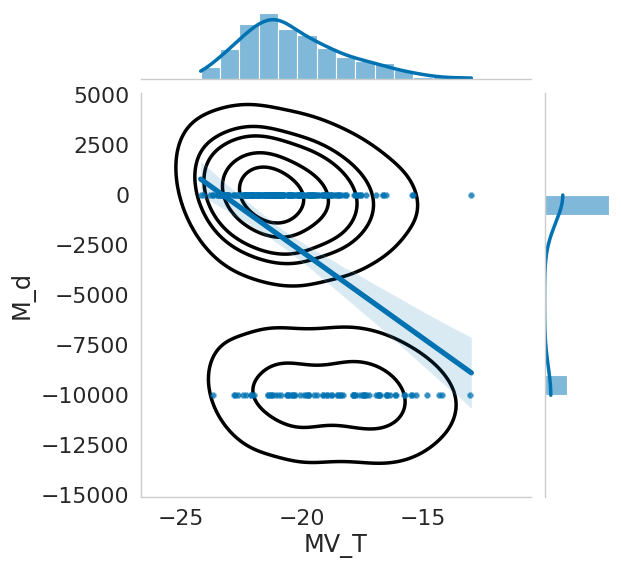

<Figure size 800x800 with 0 Axes>

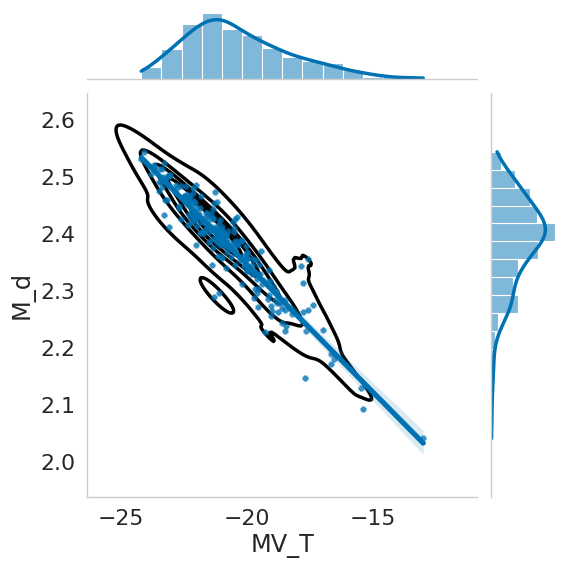

In [27]:


## plot box chart of dynamical mass
fig, ax = plt.subplots(figsize=(5, 2))
plot = sns.boxplot(data=dfgc, x=dfgc[dfgc['M_d']>0]['M_d'], ax=ax)
ax.set_xlabel('Dynamical Mass')
plt.show()

## plot jointplot of luminosity and dynamical mass
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=dfgc, x='MV_T', y='M_d',
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

## do the same but with log of dynamical mass
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=dfgc, x='MV_T', y=np.log(dfgc['M_d']),
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

We are going to see how to implement the Poisson model discussed in class, using PyMC.
The number of GCs in each galaxy is the response variable, while the absolute magnitude is the predictor. 
We have 420 galaxies in total. 

The Poisson model done in class for this problem is:

$$
N_{GC,i}\sim \text{Poisson}(\lambda_i)\\
log(\lambda_i) = 𝛽\,x_i\\
\beta|\tau \sim N(0,\tau^{-1})\\
\tau =10^{-3}
$$

Where we have assigned the broad reference prior on 𝛽.

The implementation in PyMC is straightforward.

In [2]:
with pm.Model() as poisson_log:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)

    # define linear model and exp link function
    theta = b0 + b1 * x

    ## Define Poisson likelihood
    yvar = pm.Poisson('yvar', mu=np.exp(theta), observed=y)
    trace = pm.sample(1000, return_inferencedata=True)

/tmp/ipykernel_24899/3918687498.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
/tmp/ipykernel_24899/3918687498.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [3]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-16.234,0.029,-16.294,-16.183,0.001,0.001,551.0,502.0,1.01
b1,-1.094,0.001,-1.097,-1.092,0.000,0.000,547.0,491.0,1.01


array([[<AxesSubplot: title={'center': 'b0'}>,
        <AxesSubplot: title={'center': 'b0'}>],
       [<AxesSubplot: title={'center': 'b1'}>,
        <AxesSubplot: title={'center': 'b1'}>]], dtype=object)

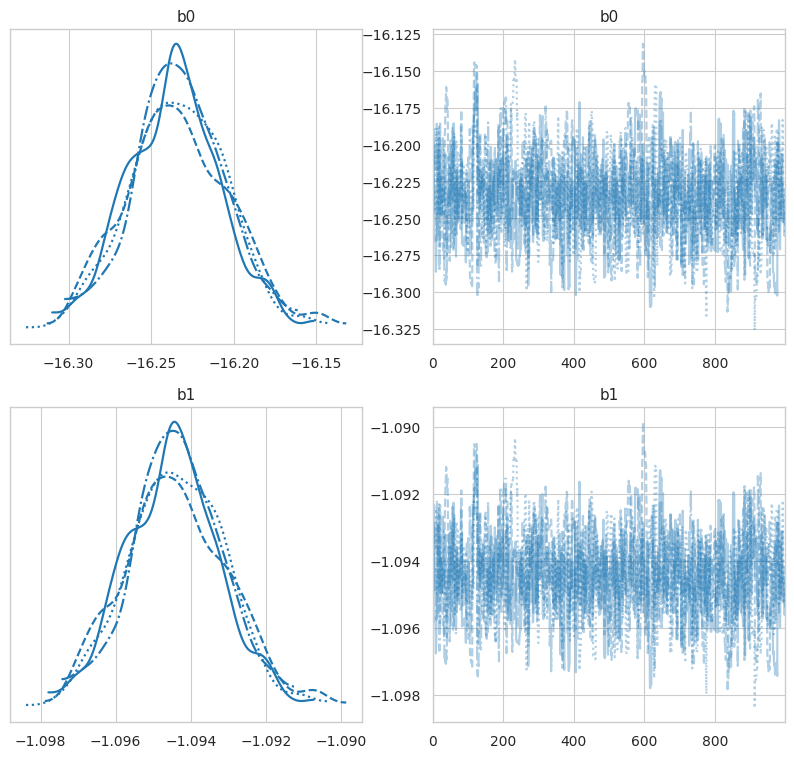

In [4]:
az.plot_trace(trace,figsize=(10, 9))

In [5]:
az.summary(trace, round_to=2)[['mean','hdi_3%','hdi_97%']]

,mean,hdi_3%,hdi_97%
b0,-16.23,-16.29,-16.18
b1,-1.09,-1.10,-1.09


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b0 -16.234  0.029 -16.294  -16.183      0.001    0.001     551.0     502.0   
b1  -1.094  0.001  -1.097   -1.092      0.000    0.000     547.0     491.0   

    r_hat  
b0   1.01  
b1   1.01  


Text(0, 0.5, 'Log(1+N$_{GC}$)')

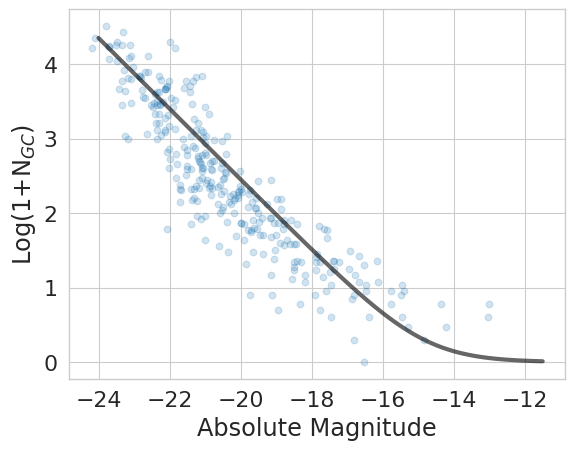

In [6]:
a = az.summary(trace)
print(a)
beta_0 = a['mean']['b0']
beta_1 = a['mean']['b1']


xt=np.linspace(-24,-11.5,100)

BF = np.exp(beta_0+xt*beta_1)

plt.scatter(x,np.log10(1+y),alpha=0.2)
plt.plot(xt,np.log10(1+BF),alpha=0.6,lw=3,color='k')

plt.xlabel(r'Xray Luminosity [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'Log(1+N$_{GC}$)')


### Negative Binomial

We saw that a different approach for data that overdispersed (i.e.,Var$<\lambda$) is to use the Negative Binomial distribution instead.

In PyMC3 the Negative Binomial is defined as:

\begin{equation} 
p(y|\lambda,\alpha) = \binom{y+\alpha -1}{y} \left( \frac{\alpha}{\lambda+\alpha} \right)^{\alpha}\left(\frac{\lambda}{\lambda+\alpha}\right)^{y}
\end{equation}

In this case, the model is: 

$$
N_{GC,i}\sim \text{NegBin}(\lambda_i,\alpha)\\
%p_i=\frac{\theta}{\theta + \lambda_i}\\
log(\lambda_i) = 𝛽\,x_i\\
\beta|\tau \sim N(0,\tau^{-1})\\
\alpha = \text{Gamma(1e-3,1e-3)}\\
\tau =10^{-3}
$$

The implementation in PyMC follows.

In [7]:
with pm.Model() as NegBin:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=41)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)
    alpha = pm.Gamma('alpha',1e-3,1e-3)
    # define linear model and exp link function
    eta = b0 + b1 * x
    lamb = np.exp(eta)
    ## Define Poisson likelihood
    yvar = pm.NegativeBinomial('yvar', mu=lamb, alpha=alpha, observed=y)
    trace_NB = pm.sample(1000, return_inferencedata=True)


/tmp/ipykernel_24899/3222389970.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=41)
/tmp/ipykernel_24899/3222389970.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([[<AxesSubplot: title={'center': 'b0'}>,
        <AxesSubplot: title={'center': 'b0'}>],
       [<AxesSubplot: title={'center': 'b1'}>,
        <AxesSubplot: title={'center': 'b1'}>],
       [<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>]], dtype=object)

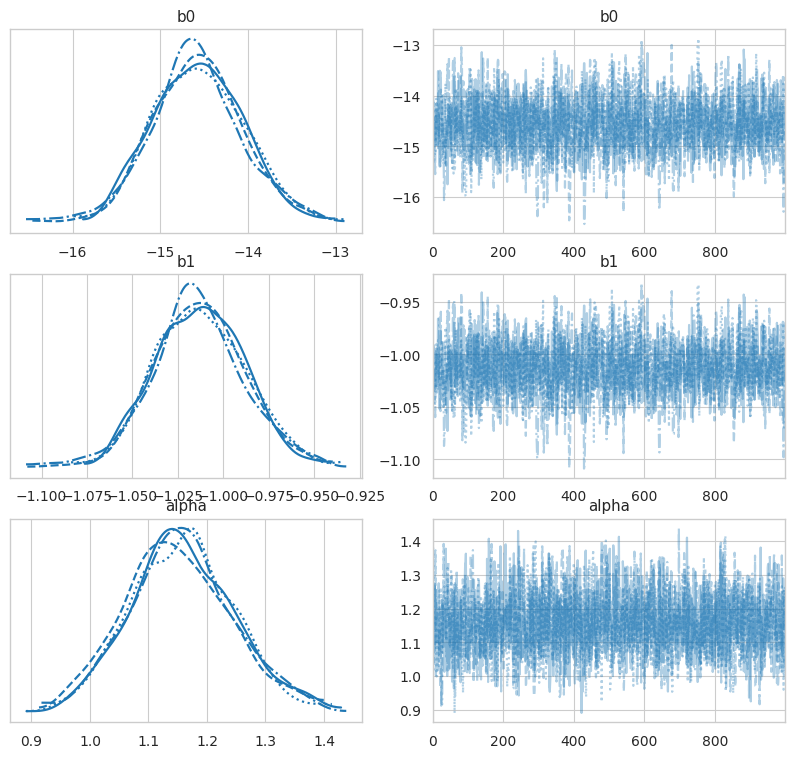

In [8]:
az.plot_trace(trace_NB,figsize=(10, 9))

In [9]:
az.summary(trace_NB)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-14.573,0.524,-15.573,-13.631,0.014,0.010,1352.0,1499.0,1.0
b1,-1.013,0.025,-1.058,-0.964,0.001,0.000,1366.0,1466.0,1.0
alpha,1.156,0.089,0.983,1.323,0.002,0.001,1837.0,1814.0,1.0


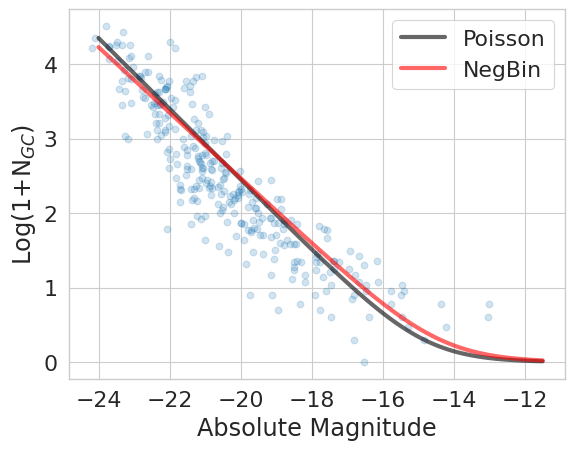

In [10]:
a_NB = az.summary(trace_NB)
beta_0_NB = a_NB['mean']['b0']
beta_1_NB = a_NB['mean']['b1']

BF_NB = np.exp(beta_0_NB+xt*beta_1_NB)

plt.scatter(x,np.log10(1+y),alpha=0.2)
plt.plot(xt,np.log10(1+BF),alpha=0.6,lw=3,color='k',label='Poisson')
plt.plot(xt,np.log10(1+BF_NB),alpha=0.6,lw=3,color='r',label='NegBin')


plt.xlabel(r'Xray Luminosity [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'Log(1+N$_{GC}$)')
plt.legend()



### Zero-Inflated Poisson Model


Sometimes we have reasons to believe that the probability of measuring a "null counts" is higher than what would be predicted by a simple Poissonian process. In this situation, we saw that we can define a Zero Inflated Probability (ZIP) model for the count variable Y. 

The ZIP probability density is:

$$
p(y) = (1-\pi)+ πe^{−θ}\,\,\,\text(for\,\, y=0)\\
p(y) = π\frac{e^{−θ}θ^y}{y!}\,\,\,\text(for\,\, y>0)
$$

This is a "mixture model"  as zero counts are modeled as coming from two generating processes: a Poisson component with probability $\pi$, and a binary component with probability (1-$\pi$).
PyMC has a built in ZIP pdf ([look here](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.ZeroInflatedPoisson.html)). 


Looking at the data, it does not look like a ZIP model is appropriate. But we can look at the results. 

In [11]:
with pm.Model() as ZIPmodel:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)

    # define linear model and exp link function
    theta = b0 + b1 * x
    pi = pm.Beta('pi',1,1)
    ## Define Poisson likelihood
    yvar = pm.ZeroInflatedPoisson('yvar', psi=pi, mu=np.exp(theta), observed=y)
    trace_ZIP = pm.sample(1000, return_inferencedata=True)



/tmp/ipykernel_24899/1162646053.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
/tmp/ipykernel_24899/1162646053.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


array([[<AxesSubplot: title={'center': 'b0'}>,
        <AxesSubplot: title={'center': 'b0'}>],
       [<AxesSubplot: title={'center': 'b1'}>,
        <AxesSubplot: title={'center': 'b1'}>],
       [<AxesSubplot: title={'center': 'pi'}>,
        <AxesSubplot: title={'center': 'pi'}>]], dtype=object)

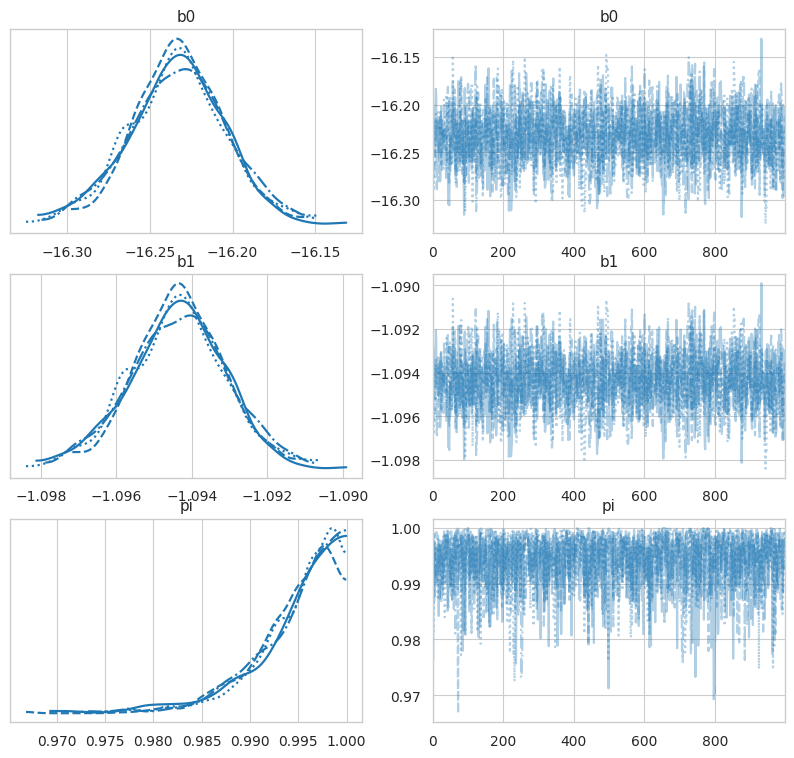

In [12]:
az.plot_trace(trace_ZIP,figsize=(10, 9))

In [13]:
az.summary(trace_ZIP)[['mean','hdi_3%','hdi_97%']]


,mean,hdi_3%,hdi_97%
b0,-16.233,-16.287,-16.178
b1,-1.094,-1.097,-1.092
pi,0.995,0.987,1.000


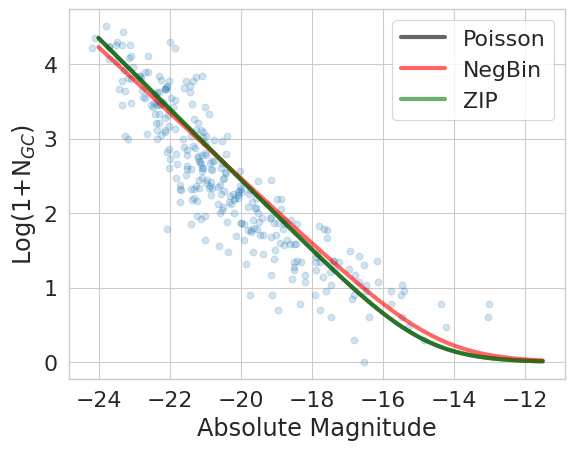

In [14]:
a_ZIP = az.summary(trace_ZIP)
beta_0_ZIP = a_ZIP['mean']['b0']
beta_1_ZIP = a_ZIP['mean']['b1']

BF_ZIP = np.exp(beta_0_ZIP+xt*beta_1_ZIP)

plt.scatter(x,np.log10(1+y),alpha=0.2)
plt.plot(xt,np.log10(1+BF),alpha=0.6,lw=3,color='k',label='Poisson')
plt.plot(xt,np.log10(1+BF_NB),alpha=0.6,lw=3,color='r',label='NegBin')
plt.plot(xt,np.log10(1+BF_ZIP),alpha=0.6,lw=3,color='g',label='ZIP')


plt.xlabel(r'Xray Luminosity [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'Log(1+N$_{GC}$)')
plt.legend()




## Quadratic or linear in Absolute Magnitude?

From the plot above,we can see that none of the three models really does a good job at predicting the numbers of globulare clusters in galaxies with $M_V \approx -20$.

We can see if a quadratic function in the predictor works better. We will still assume a Poissonian model for the number of globular clusters. Now our model is: 


$$
N_{GC,i}\sim \text{Poisson}(\lambda_i)\\
log(\lambda_i) = \beta_0+\beta_1\,x_i +\beta_2\,x_i^2 \\
\beta|\tau \sim N(0,\tau^{-1})\\
\tau =10^{-3}
$$



In [15]:
order = 2
with pm.Model() as quadratic:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3)
    b1 = pm.Normal('b1', mu=0, tau=1e-3)
    b2 = pm.Normal('b2', mu=0, tau=1e-3)

    # define linear model and exp link function
    theta = b0 + b1 * x + b2 * pm.math.sqr(x)

    ## Define Poisson likelihood
    yvar = pm.Poisson('yvar', mu=np.exp(theta), observed=y)
    trace_QD = pm.sample(100000, return_inferencedata=True,step=pm.Metropolis())
    


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b0]
>Metropolis: [b1]
>Metropolis: [b2]


/home/bipar001/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/bipar001/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/bipar001/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/bipar001/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 211 seconds.


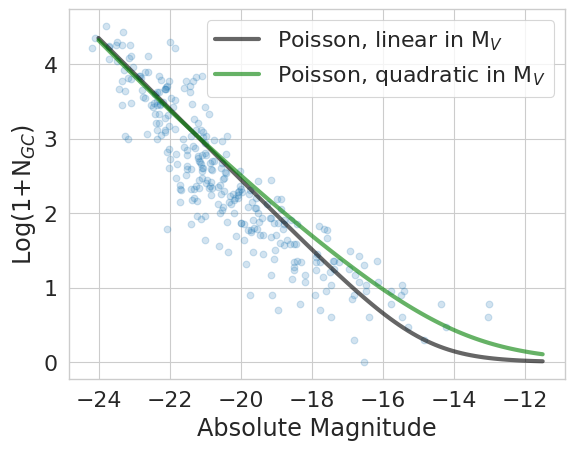

In [16]:
a_QD = az.summary(trace_QD)
beta_0_QD = a_QD['mean']['b0']
beta_1_QD = a_QD['mean']['b1']
beta_2_QD = a_QD['mean']['b2']
BF_QD = np.exp(beta_0_QD+xt*beta_1_QD+xt**2*beta_2_QD)

plt.scatter(x,np.log10(1+y),alpha=0.2)
plt.plot(xt,np.log10(1+BF),alpha=0.6,lw=3,color='k',label=r'Poisson, linear in M$_V$')
plt.plot(xt,np.log10(1+BF_QD),alpha=0.6,lw=3,color='g',label=r'Poisson, quadratic in M$_V$')

plt.xlabel(r'Xray Luminosity [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.xlabel(r'Absolute Magnitude')
plt.ylabel(r'Log(1+N$_{GC}$)')
plt.legend()



In [17]:
az.summary(trace_QD)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-6.944,1.107,-8.237,-5.495,0.464,0.374,5.0,11.0,2.53
b1,-0.296,0.071,-0.379,-0.210,0.035,0.027,4.0,11.0,3.45
b2,0.017,0.002,0.015,0.020,0.001,0.001,5.0,12.0,2.36


The quadratic fit seems to be doing a better job, but on the faint side it seems a little worse. We can use PyMC to look at the posterior predictive samples for both models. 

We can also perform a quantitative comparison using the LOO method (and others)  we discussed in class. (See also [Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Stat Comput 27, 1413–1432 (2017)](https://doi.org/10.1007/s11222-016-9696-4)).

Also read the arviz explanation [here](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html).



## Truncated data -- Poissonian example

Normal example [here](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-truncated-censored-regression.html).

Next, we look at an example in which we know that the data are truncated in some ways. 
Suppose we have a statistical model to generate the data Y. If we now that there are some values of Y that are impossible to observe, then we talk about truncation. 

As an exaple you can think of the measured sizes of a galaxy. Either the instrumental point-spread- function or the seeing provide a minimum size we can measure. So we know that sizes smaller than the PSF have probability of zeros. 

In the next example we look at the number of galaxy in groups and clusters as a function of their X-ray luminosity. This latter quantity is proportional to the total mass of the cluster (DM+baryonic) so it is expected to correlate with the number of galaxies, to first approximation. 

The next few cells show the data, and the Poisson model using all the data.  

Text(0, 0.5, 'Number of galaxies')

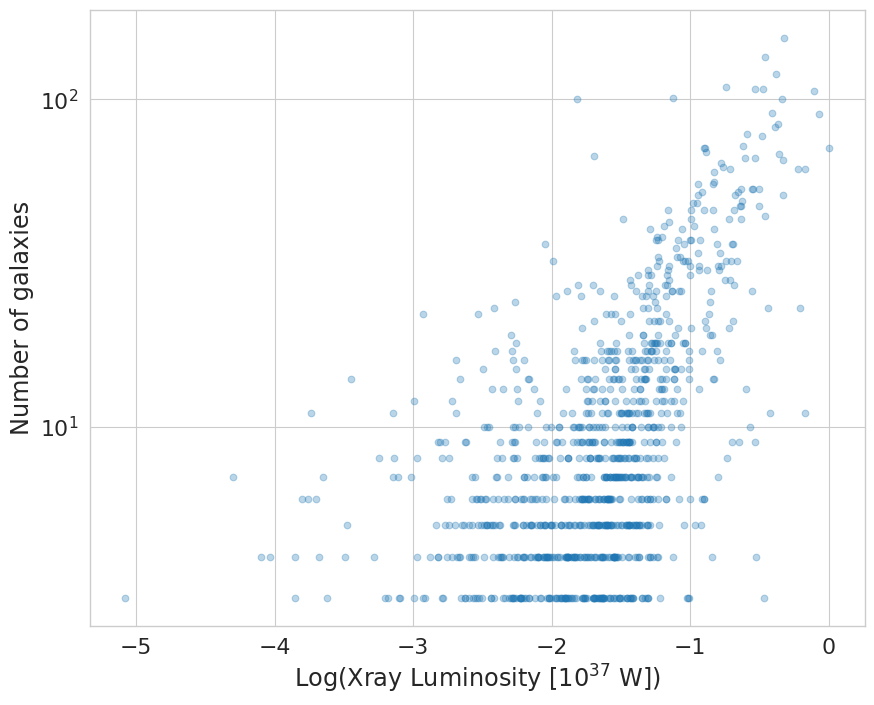

In [18]:
import pandas as pd

plt.figure(figsize=(10,8))

data = pd.read_csv('clusters_xrays.csv')
x=np.log10(data['LX'])
y=data['Ngal']

plt.scatter(x,y,alpha=0.3)
plt.yscale('log')
plt.xlabel(r'Log(Xray Luminosity [10$^{37}$ W])')
plt.ylabel('Number of galaxies')

In [19]:
with pm.Model() as poisson_log:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.)

    # define linear model and exp link function
    theta = b0 + b1 * x

    ## Define Poisson likelihood
    yvar = pm.Poisson('yvar', mu=np.exp(theta), observed=y)
    trace = pm.sample(4000, return_inferencedata=True)

/tmp/ipykernel_24899/1714256894.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.)
/tmp/ipykernel_24899/1714256894.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 12 seconds.


,mean,hdi_3%,hdi_97%
b0,4.39,4.35,4.43
b1,1.24,1.21,1.27


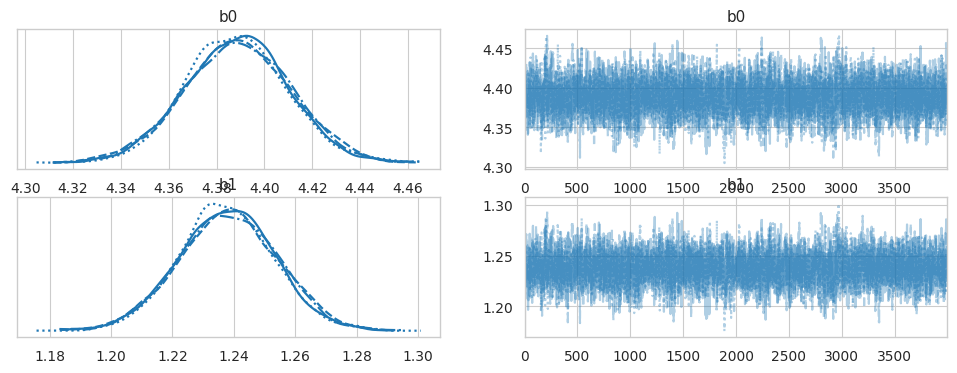

In [20]:
az.plot_trace(trace)
az.summary(trace, round_to=2)[['mean','hdi_3%','hdi_97%']]

But is the above correct?

Let's consider the situation in which I want to limit the analysis to only systems with at least $N$ galaxies (for example, if I want to mesure a velocity dispersion I need to have more than a few members). 

This means that for a given X-ray luminosity, some parts of the Poisson distribution cannot be observed. As an example, suppose that for Log(LX)=-2 we have λ=5. The figure below shows the portion of the Poisson distribution that we are sampling by truncating the number of galaxies to be equal or greater than ```limit```.

Text(0.5, 0, 'Number of galaxies')

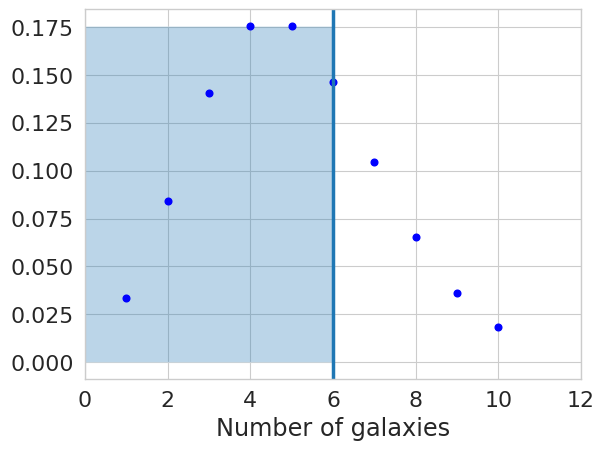

In [21]:
from scipy.stats import poisson
limit=6

mu=5
xx = np.arange(poisson.ppf(0.01, mu),poisson.ppf(0.99, mu))
plt.plot(xx, poisson.pmf(xx, mu), 'bo', label='poisson pmf')
plt.axvline(limit)
plt.fill_between([0,limit,limit,0],[0,0,np.max(poisson.pmf(xx, mu)),np.max(poisson.pmf(xx, mu))],alpha=0.3)
plt.xlim(0,12)
plt.xlabel('Number of galaxies')

In [22]:
use = y>limit
with pm.Model() as poisson_log_truncated:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.5)

    # define linear model and exp link function
    theta = b0 + b1 * x[use]

    ## Define Poisson likelihood
    yvar = pm.Poisson('yvar', mu=np.exp(theta), observed=y[use])
    trace_truncated = pm.sample(4000, return_inferencedata=True)

/tmp/ipykernel_24899/1031980758.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.)
/tmp/ipykernel_24899/1031980758.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.5)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 11 seconds.


,mean,hdi_3%,hdi_97%
b0,4.369,4.325,4.411
b1,1.052,1.019,1.086


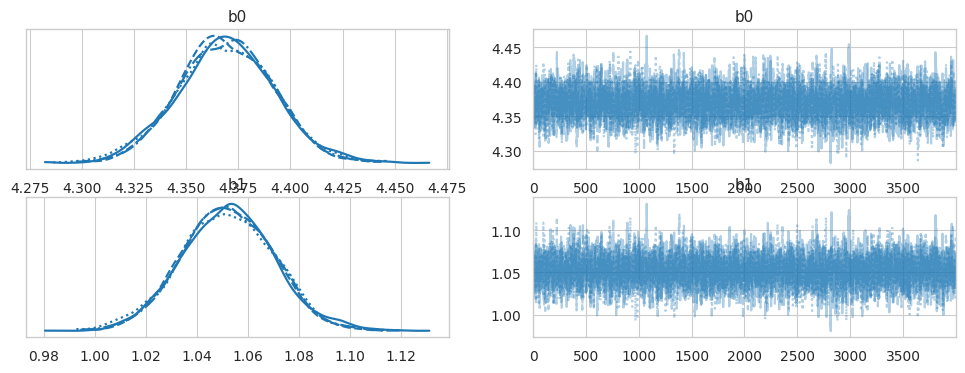

In [23]:
az.plot_trace(trace_truncated)
az.summary(trace_truncated)[['mean','hdi_3%','hdi_97%']]

(1, 800)

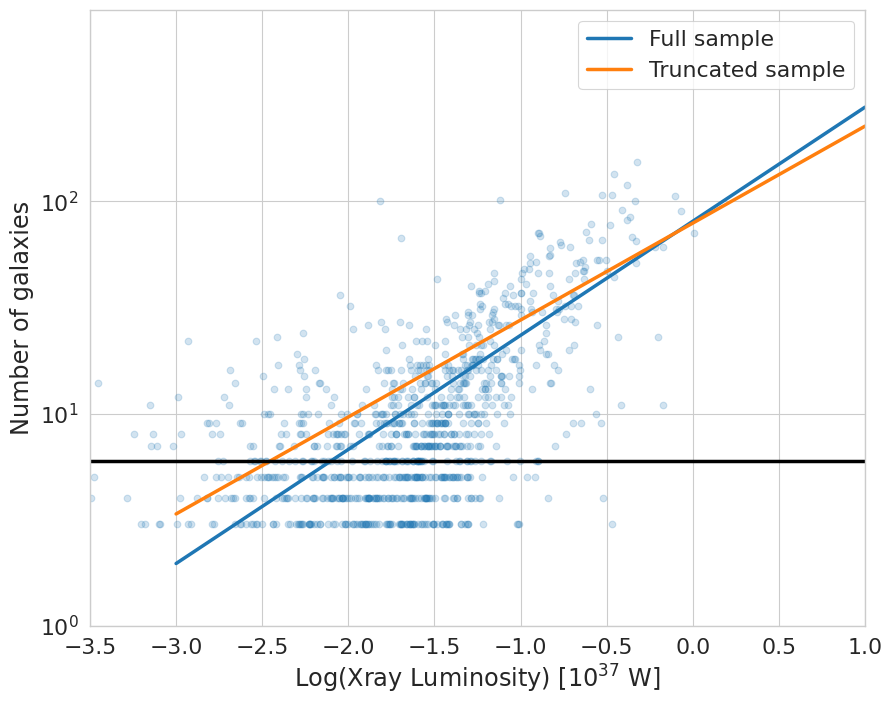

In [24]:
xt=np.linspace(-3,1,1000)
plt.figure(figsize=(10,8))


plt.scatter(x,y,alpha=0.2)
plt.yscale('log')

a = az.summary(trace)
b0 = a['mean']['b0']
b1 = a['mean']['b1']

BF =  np.exp(b0 + b1*xt)

aT = az.summary(trace_truncated)
b0T = aT['mean']['b0']
b1T = aT['mean']['b1']

BFT = np.exp(b0T + b1T*xt)

plt.xlabel(r'Log(Xray Luminosity) [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.plot(xt,BF,label='Full sample')
plt.plot(xt,BFT,label='Truncated sample')
plt.axhline(limit,color='k')
plt.legend()
plt.xlim(-3.5,1)
plt.ylim(1,800)

The way to proceed in this case is to change the likelihood of the data, as we know that the likelihood of observing any number smaller than the limit we set is 0.

We need to use a [truncated](https://en.wikipedia.org/wiki/Truncated_distribution) Poisson distribution. 

The Poisson is:

$$ 
f(y) = \frac{\lambda^y e^{-\lambda}}{y!}
$$

The truncated Poisson g(y) is given by:

$$
f(y|Y>a) = \frac{g(y)}{F(\infty)-F(a)}
$$

Where F(y) is the cumulative distribution function for p(y), and g(x) is the modified Poisson PDF which is zero for y$\le$a. (Basically after "cutting" the PDF we need to renormalize it to account for the missing probability). F(∞)=1, so we easily find (e.g., [here](https://en.wikipedia.org/wiki/Zero-truncated_Poisson_distribution)):

$$
g(y) = \frac{f(y| λ)}{F(\infty)-F(a|λ)} = \frac{λ^y}{y!(e^ λ - \sum_{i=0}^{a}\frac{\lambda^i}{i!})}
$$

So we can implement the log distribution in PyMC

In [45]:
print(x[use].shape)
import multiprocessing as mp


with pm.Model() as poisson_pdf_tr:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.370)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.2)

    # define linear model and exp link function
    theta = b0 + b1 * x[use]

    ## Define Poisson likelihood
    #step = pm.Metropolis()
    Poisson_dist = pm.Normal.dist(mu=np.exp(theta))
    yvar = pm.Truncated("yvar", Poisson_dist, lower=6,observed=y[use])
    trace_tt = pm.sample(5000,return_inferencedata=True, cores=1,mp_ctx="forkserver")



(586,)


/var/folders/mt/j5_ht1ns57zcwpnlm45sqzwr0000gn/T/ipykernel_35308/3363363298.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=4.370)
/var/folders/mt/j5_ht1ns57zcwpnlm45sqzwr0000gn/T/ipykernel_35308/3363363298.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1.2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b0, b1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.


(1, 800)

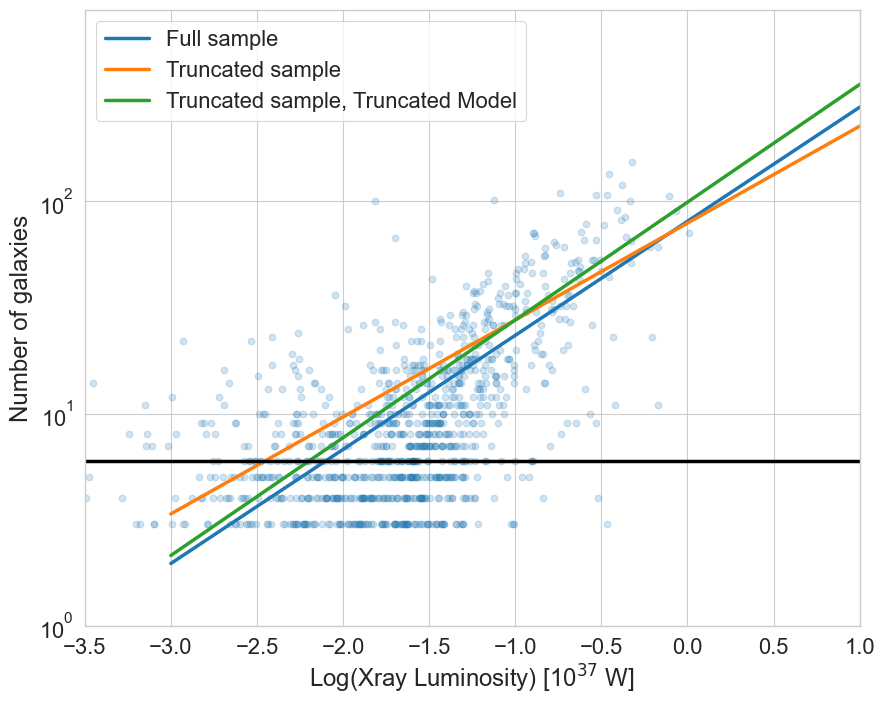

In [46]:
plt.figure(figsize=(10,8))

plt.scatter(x,y,alpha=0.2)
plt.yscale('log')

a_tt = az.summary(trace_tt)
b0 = a_tt['mean']['b0']
b1 = a_tt['mean']['b1']

BFTM =  np.exp(b0 + b1*xt)


plt.xlabel(r'Log(Xray Luminosity) [10$^{37}$ W]')
plt.ylabel('Number of galaxies')

plt.plot(xt,BF,label='Full sample')
plt.plot(xt,BFT,label='Truncated sample')
plt.plot(xt,BFTM,label='Truncated sample, Truncated Model')

plt.axhline(limit,color='k')
plt.legend()
plt.xlim(-3.5,1)
plt.ylim(1,800)